<a href="https://colab.research.google.com/github/connor-verheyen/DataDrivenGranularHydrogels/blob/main/analysis/Model_Predicting_PhaseSep_VolumeFraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import basic libraries 
import os 
import pandas as pd 
import numpy as np 
import scipy as sp 
import math
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

In [ ]:
# Read the csv sheet into a dataframe 
test = pd.read_csv('https://raw.githubusercontent.com/connor-verheyen/DataDrivenGranularHydrogels/main/data/Dataset_PhaseSepVolumeFractionEstimation.csv')

In [ ]:
# Define dictionaries for ordinal categorical data label encoding 

stiffness_map = {'SOFTEST': 0,
                 'VERY SOFT': 1,
                 'SOFTER': 2,
                 'SOFT': 3,
                 'VERY STIFF': 5}

# Map the dictionaries to each feature column to encode each category with a specific numerical label 

test['Rel. Microgel Stiffness'] = test['Relative Stiffness'].map(stiffness_map) # Ordinal categorical 

# Rename the rest of the columns that will be used as inputs 
test.rename(columns={'Particle Concentration': 'Microgel Conc. (wt.%)', 
                     'Solvent Ca conc': 'Fluid Ca2+ (mM)', 
                     'Solvent Na conc': 'Fluid Na+ (mM)',
                     'Vol of Particles After Settling (mL)': 'Settled Solid Vol. (mL)',
                     'Total Volume After Settling (Particles + Excess PBS) ': 'Settled Total Vol. (mL)',
                     'Applied Pressure (PSI)': 'Jam Pressure (PSI)', 
                     'Filter Pore Size (um)': 'Membrane Pore Size (um)', 
                     'Time (min)': 'Jam Duration (min)',
                     'Solid Volume of Particles ': 'Assumed Solid Vol. (mL)', 
                     'Est. Volume Fraction ': 'Est. Vol. Fraction'
                     },inplace=True)

# Add a unique ID for each trial (identify unique trials by finding the points in the dataframe where Jam Duration == 0, indicating the start of an independent trial)

counter=0; test['Unique ID'] = np.nan # initialize a unique ID counter and initialize an empty column 

# Go through each row in the dataframe 
for i in test.index:

  if test.loc[i,'Jam Duration (min)']==0: # Check if the Jam Duration is equal to zero 
     
     test.loc[i,'Unique ID']=counter; counter+=1; # Add the unique ID to the dataframe in that location and then increment the counter (so that the next location where Jam Duration==0 will get its own unique value)

test['Unique ID'].fillna(method='ffill',inplace=True) # Use forwward fill to fill all of the NaN values with the appropriate unique ID 

In [ ]:
# Imports for stratified k-fold cross-validation and grid-search cross-validation 
from sklearn.model_selection import RepeatedKFold, KFold, GridSearchCV, cross_validate, GroupKFold, GroupShuffleSplit

# Import for constructing a ML pipeline 
from sklearn.pipeline import Pipeline

# Imports for evaluating the predictive power of the trained models 
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, median_absolute_error, mean_squared_error, max_error

# Imports for different classifier algorithms 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Function to perform manual nested cross validation
# Allows you to store all inner cross-validation results, all model params, all outer testing and prediction results, and best models and their unbiased accuracy scores 

def manual_nested_cross_validation_regression(model, grid, cv_inner, cv_outer, algo_name, X, y, scoring, refit, groups): # Note, model can also be a sklean pipeline 
  
  outer_results = [] # hold all of the results from the outer cross-validation (Xtest,ytest,yhat) -> outer loop = unbiased evaluation of model accuracy/usefulness of the best models selected during the inner loop 
  inner_results = [] # hold all of the results from the inner cross-validation (inner training accuracy (mean,std), inner test accuracy (mean,std), all model parameters) -> inner loop = hyperparameter tuning 
  best_models = [] # hold all of the best-performing models from the inner cross-validation (stores the model objects, can be used to fit and predict if given other data)
  outer_r2 = []; outer_MAE = []; outer_MedAE = []; outer_RMSE = [] # hold all of the scores after training the best inner model and testing on the outer test set (compare yhat from best inner model to outer ytest)
  
  # Go through each of the outer train/test sets -> note, this works when using StratifiedKFold, not sure if it works with all sklearn cross-validation functions... 
  for train_ix, test_ix in cv_outer.split(X,y,groups=groups): # split generates an ndarray of values corresponding to the indices of the train and test data for each fold  

    # Split the data according to membership in the train or test set -> turn the ndarray (from split) into a list and then use iloc to index the dataset at the correct locations 
    X_train, X_test = X.iloc[train_ix.tolist(),:].reset_index(drop=True), X.iloc[test_ix.tolist(), :].reset_index(drop=True) # inputs 
    y_train, y_test = y.iloc[train_ix.tolist()].reset_index(drop=True), y.iloc[test_ix.tolist()].reset_index(drop=True) # outputs 

    # Define the inner grid search 
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score =True, cv=cv_inner, scoring=scoring, error_score=0, refit=refit)

	  # Execute the inner grid search -> outer training and test sets will be further broken into inner training and inner validation sets by GridSearch
    grid_result = grid_search.fit(X_train, y_train, groups=groups[train_ix])

    # Go through each of the scoring metrics you defined and get the mean test scores, std test scores, mean train scores, and std train scores for each of the models 
    values_to_store = ['mean_test_','std_test_','mean_train_','std_train_']; inner_scores = {}
    for scorer in scoring.keys():
      for values in values_to_store: 
        inner_scores[values+scorer] = grid_result.cv_results_[values+scorer] # store all of the results in a dict (mean and std computed based on each of the unique folds of the inner loop ) 
    scores = pd.DataFrame(inner_scores)

    # Get the parameters for each of the models 
    parameters = pd.DataFrame(grid_result.cv_results_['params'])

    # Concatenate the inner scores and parameters, rank by test score, drop the scores of 0 (parameter combinations that don't work), and reset index 
    results_df = pd.concat([scores,parameters],axis=1).sort_values(by=('mean_test_'+refit),ascending=False)
    results_df = results_df[results_df['mean_test_'+refit] != 0].reset_index(drop=True)
    inner_results.append(results_df)

	  # Get the best performing model selected by GridSearch (model was re-fit on the entire outer training set (=inner train + inner validation), accomplished by setting "refit" = True)
    best_model = grid_result.best_estimator_; best_models.append(best_model) # Add the best model to the list 

	  # Make predictions using the best performing model (trained on entire outer training set) on the hold out dataset (outer test set)
    yhat = best_model.predict(X_test) # Predicted values for samples in X_test 

	  # Evaluate the model accuracy by comparing model predictions to the hold out dataset (outer test set) -> Comment out the ones you don't want to use 
    r2 = r2_score(y_test, yhat); outer_r2.append(r2) # Add the outer test r2 score to the list 
    MAE = mean_absolute_error(y_test, yhat); outer_MAE.append(MAE) # Add the outer test MAE to the list 
    MedAE = median_absolute_error(y_test, yhat); outer_MedAE.append(MedAE) # Add the outer test Median AE to the list 
    RMSE = mean_squared_error(y_test, yhat, squared=False); outer_RMSE.append(RMSE) # Add the outer test RMSE to the list 

    # Create a dataframe with outer X_test, outer ytest, outer yhat, and outer yprob 
    y_test_df = pd.DataFrame({'y_test': y_test}); yhat_df = pd.DataFrame({'yhat': yhat}); 
    outer = pd.concat([X_test.reset_index(drop=True), y_test_df.reset_index(drop=True), yhat_df.reset_index(drop=True)],axis=1)
    outer_results.append(outer) # Add the outer results to the list 

  # Concatenate the dataframes produced in the loops -> keys correspond to the specific fold within the k-fold cross-validation 
  inner_results_df = pd.concat(inner_results,keys=np.arange(0,len(inner_results)))
  outer_results_df = pd.concat(outer_results,keys=np.arange(0,len(outer_results)))
  best_models_df = pd.concat([pd.DataFrame({'best_model': best_models}), 
                              pd.DataFrame({'outer_r2': outer_r2}),  # Comment out the ones you don't want to add to the dataframe
                              pd.DataFrame({'outer_MAE': outer_MAE}), 
                              pd.DataFrame({'outer_MedAE': outer_MedAE}), 
                              pd.DataFrame({'outer_RMSE': outer_RMSE}), 
                              ], axis=1)

  # Print the classification accuracy 
  print(f'Best-performing {algo_name} model inner {refit} was {round(inner_results_df.xs(key=0,level=1)["mean_test_"+refit].mean(),3)} +/- {round(inner_results_df.xs(key=0,level=1)["std_test_"+refit].mean(),3)}')
  print(f'Best-performing {algo_name} model outer {refit} was {round(np.mean(best_models_df["outer_"+refit]),3)} +/- {round(np.std(best_models_df["outer_"+refit]),3)}')

  return inner_results_df, outer_results_df, best_models_df

In [ ]:
data = test

# Features
X = data[['Microgel Conc. (wt.%)', ###
          'Fluid Ca2+ (mM)', ###
          'Fluid Na+ (mM)', ###
          'Settled Solid Vol. (mL)',
          'Settled Total Vol. (mL)', 
          'Jam Pressure (PSI)',
          'Membrane Pore Size (um)',
          'Jam Duration (min)',
       ]]

# Labels
y = data['Est. Vol. Fraction']

# Groups 
groups = data['Unique ID'].values

In [ ]:
# Build a dictionary to hold all models and sub-dictionaries of model hyperparameters -> accessible via "name" key 
algo_dict = {}

# Random Forest 
name = 'Random Forest'; model = RandomForestRegressor()

n_estimators = [10, 100, 1000]; max_features = ['sqrt', 'log2']; n_jobs=[-1]

grid = dict(n_estimators=n_estimators,max_features=max_features, n_jobs=n_jobs)

algo_dict[name] = {'model': model, 'grid': grid}

# Gradient Boosting
name = 'Gradient Boosting'; model = GradientBoostingRegressor()

n_estimators = [10, 100, 1000]; learning_rate = [0.001, 0.01, 0.1]; subsample = [0.5, 0.7, 1.0]; max_depth = [3, 7, 9]

grid = dict(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, max_depth=max_depth)

algo_dict[name] = {'model': model, 'grid': grid}

In [ ]:
# Configure the inner cross validation procedure -> used for hyperparameter tuning 
gkf_inner = GroupKFold(n_splits=2)


# Configure the outer cross validation procedure -> used for evaluating the accuracy & generalizability of the tuned model on unseen test data 
gkf_outer = GroupKFold(n_splits=5)

In [ ]:
# Build a dictionary to hold the scorer functions for evaluating the predictive power of the trained models 
scoring_dict = {'r2': make_scorer(r2_score),
                'MAE': make_scorer(mean_absolute_error), 
                'MedAE': make_scorer(median_absolute_error), 
                'RMSE': make_scorer(mean_squared_error, squared=False),
                }
refit = 'r2'

In [ ]:
import time
start_time = time.time()

inner_results = []; outer_results = []; best_models = [] # lists to store all of the results so you can concatenate into multi-index df at the end
# Go through each algorithm and perform inner grid search and outer cross validation and store all results 
for key in algo_dict.keys():
  model = algo_dict[key]['model'] # get the model from the model dict 
  
  grid = algo_dict[key]['grid'] # get the grid search space from the grid dict 
  
  grid_for_pipe = {'model__'+key: grid[key] for key in grid.keys()} # go through existing grid and modify the names with "model__" format so they can be used with the pipeline object 

  # Build data pipeline that will A) fit/transform the train and transform the test and then B) apply the algorithm 
  pipe = Pipeline([
                   ('model', model) # model was defined by the model dict (accessed within the loop)
                   ])
  
  # Run the manual nested cross validation 
  inner, outer, best = manual_nested_cross_validation_regression(pipe, grid_for_pipe, gkf_inner, gkf_outer, key, X, y, scoring=scoring_dict, refit=refit, groups=groups)
  inner_results.append(inner); outer_results.append(outer); best_models.append(best) # store all results 

# Print out the amount of time it takes to complete nested cross-validation for the models 
print("--- %.3f minutes ---" % ((time.time() - start_time)/60))

Best-performing Random Forest model inner r2 was 0.736 +/- 0.032
Best-performing Random Forest model outer r2 was 0.734 +/- 0.139
Best-performing Gradient Boosting model inner r2 was 0.793 +/- 0.038
Best-performing Gradient Boosting model outer r2 was 0.766 +/- 0.085
--- 2.657 minutes ---


In [ ]:
# Compile the inner cross-validation results, the outer cross-validation results, and the best-performing models and their outer accuracy scores
compiled_inner_crossval = pd.concat(inner_results,keys=algo_dict.keys()); compiled_outer_crossval = pd.concat(outer_results,keys=algo_dict.keys()); compiled_best_models = pd.concat(best_models,keys=algo_dict.keys())

# Drop the columns you don't want to plot for the evaluation metrics 
evaluation = compiled_best_models.drop(columns={'best_model','outer_RMSE'})

# Check out the mean evaluation metrics 
compiled_best_models.reset_index().drop(columns={'level_1'}).groupby('level_0').mean()

# Check out the mean evaluation metrics for the averaged ensemble model 
compiled_best_models.mean().to_frame().T.rename(index={0:'Averaged Model'})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  # This is added back by InteractiveShellApp.init_path()


,outer_r2,outer_MAE,outer_MedAE,outer_RMSE
Averaged Model,0.750285,0.059846,0.051858,0.074402


In [ ]:
# Output the descriptive statistics for the averaged model evaluation metrics 
round(evaluation.reset_index().groupby('level_1').mean().describe().iloc[1:],3)

,outer_r2,outer_MAE,outer_MedAE
mean,0.750,0.060,0.052
std,0.125,0.018,0.014
min,0.567,0.041,0.035
25%,0.693,0.045,0.041
50%,0.766,0.058,0.055
75%,0.857,0.077,0.058
max,0.867,0.078,0.070


In [ ]:
# Print the mean+std and median for each averaged model metric (evaluated on unseen outer loop data)
for col in evaluation.columns: 
  avgd = round(evaluation.reset_index().groupby('level_1')[col].mean().describe().iloc[1:],3)
  print(col.lstrip('outer_'))
  print(' Mean +/- SD = ',avgd['mean'],'+/-',avgd['std'])
  print(' Median = ',avgd['50%'],'\n')

2
 Mean +/- SD =  0.75 +/- 0.125
 Median =  0.766 

MAE
 Mean +/- SD =  0.06 +/- 0.018
 Median =  0.058 

MedAE
 Mean +/- SD =  0.052 +/- 0.014
 Median =  0.055 



In [ ]:
# Now set up another CV and execute the final grid search optimization

# Build a dictionary to hold the scorer functions for evaluating the predictive power of the trained models 
scoring_dict = {'r2': make_scorer(r2_score),
                'MAE': make_scorer(mean_absolute_error), 
                'MedAE': make_scorer(median_absolute_error), 
                }
refit = 'r2'

# Configure the final cross validation procedure -> used for tuning the final model 
cv_final = GroupKFold(n_splits=5)

# Save the best models from the grid search and use them to fit the entire dataset 

search_results=[]; best_models=[]
# Go through each algorithm and perform inner grid search and outer cross validation and store all results 
for key in algo_dict.keys():
  model = algo_dict[key]['model'] # get the model from the model dict 
  
  grid = algo_dict[key]['grid'] # get the grid search space from the grid dict 
  
  grid_for_pipe = {'model__'+key: grid[key] for key in grid.keys()} # go through existing grid and modify the names with "model__" format so they can be used with the pipeline object 

  # Build data pipeline that will A) fit/transform the train and transform the test and then B) apply the algorithm 
  pipe = Pipeline([
                   ('model', model) # model was defined by the model dict (accessed within the loop)
                   ])
  
  # Define the final grid search 
  grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, return_train_score =True, cv=cv_final, scoring=scoring_dict, error_score=0, refit=refit)

	# Execute the final grid search -> outer training and test sets will be further broken into inner training and inner validation sets by GridSearch
  grid_result = grid_search.fit(X, y, groups=groups)

  # Go through each of the scoring metrics you defined and get the mean test scores, std test scores, mean train scores, and std train scores for each of the models 
  values_to_store = ['mean_test_','std_test_','mean_train_','std_train_']; inner_scores = {}
  for scorer in scoring_dict.keys():
    
    for values in values_to_store: 
    
      inner_scores[values+scorer] = grid_result.cv_results_[values+scorer] # store all of the results in a dict (mean and std computed based on each of the unique folds of the inner loop ) 
    
  scores = pd.DataFrame(inner_scores)

  # Get the parameters for each of the models 
  parameters = pd.DataFrame(grid_result.cv_results_['params'])

  # Concatenate the inner scores and parameters, rank by test score, drop the scores of 0 (parameter combinations that don't work), and reset index 
  results_df = pd.concat([scores,parameters],axis=1).sort_values(by=('mean_test_'+refit),ascending=False)
    
  results_df = results_df[results_df['mean_test_'+refit] != 0].reset_index(drop=True)
    
  search_results.append(results_df)

	# Get the best performing model selected by GridSearch (model was re-fit on the entire outer training set (=inner train + inner validation), accomplished by setting "refit" = True)
  best_model = grid_result.best_estimator_; best_models.append(best_model) # Add the best model to the list 

In [ ]:
# Compile the cross-validated grid search results 
final_search_results = pd.concat(search_results,keys=algo_dict.keys()); 

# Get the highest-scoring model from the list of best models for each algorithm (allows you to select for the algorithm with optimal hyperparameters)
rf = best_models[0] 

gbm = best_models[1] 

# Store the selected models in a new dict
selected = {'RF': rf, 'GBM': gbm}

In [ ]:
# Fit the final selected models to the ENTIRE available dataset 
rf.fit(X,y); gbm.fit(X,y);

In [ ]:
# Create synthetic n-dimensional dataset (based on training data) and then visualize 2-dimensional slices / maps of the n-dimensional space 

# Generate possible combinations of features 

import itertools

unique_vals_manual = {}

# Add user-defined unique values for each feature to the dict (Lots of unique vals for each feature, do this manually so you don't get a dataframe with 1795500 rows...)
unique_vals_manual['Settled Solid Vol. (mL)'] = np.array([30,50])
unique_vals_manual['Settled Total Vol. (mL)'] = np.array([35,75])
unique_vals_manual['Jam Pressure (PSI)'] = np.array([0,2])
unique_vals_manual['Membrane Pore Size (um)'] = np.array([11,70]) 
unique_vals_manual['Jam Duration (min)'] = np.array([0,30]) #unique_vals_manual['Jam Duration (min)'] = np.array([1,60])
unique_vals_manual['Microgel Conc. (wt.%)'] = np.array([0.25,2]) ###
unique_vals_manual['Fluid Ca2+ (mM)'] = np.array([0.9,2]) ###
unique_vals_manual['Fluid Na+ (mM)'] = np.array([0,150]) ###

other_vars_constant = pd.DataFrame(list(itertools.product(*unique_vals_manual.values())), columns=unique_vals_manual.keys()) # Use itertools to generate every possible feature combination. Combine all of the possible feature combinations into a single dataframe 

# Compute class predictions and probabilities (of each class) for each possible feature combination  
level_0 = []
for key in selected.keys(): 
  
  copy = other_vars_constant.copy() # Copy the dataframe where features are varied while others are held constant 
  
  copy['Pred'] = selected[key].predict(other_vars_constant[X.columns])

  level_0.append(copy)

other_vars_constant = pd.concat(level_0,keys=selected.keys()).reset_index().drop(columns='level_1').rename(columns={'level_0':'Model'})

In [ ]:
# Set seaborn plotting styles 
sns.set(context='talk', font_scale=0.9, style='ticks',palette='Greens_d')

In [ ]:
# To export the processed input (X) and output data (y) as a combined dataframe 
pd.concat([X,y],axis=1).to_csv('Data_for_Model_Predicting_PhaseSep_VolumeFraction.csv')

# To export the matrix of data-driven predictions as a dataframe
other_vars_constant.to_csv('Predictions_for_Model_Predicting_PhaseSep_VolumeFraction.csv')

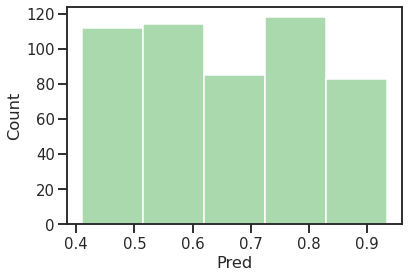

In [ ]:
# To visualize the distribution of data-driven predictions
sns.histplot(other_vars_constant['Pred'],bins=5)

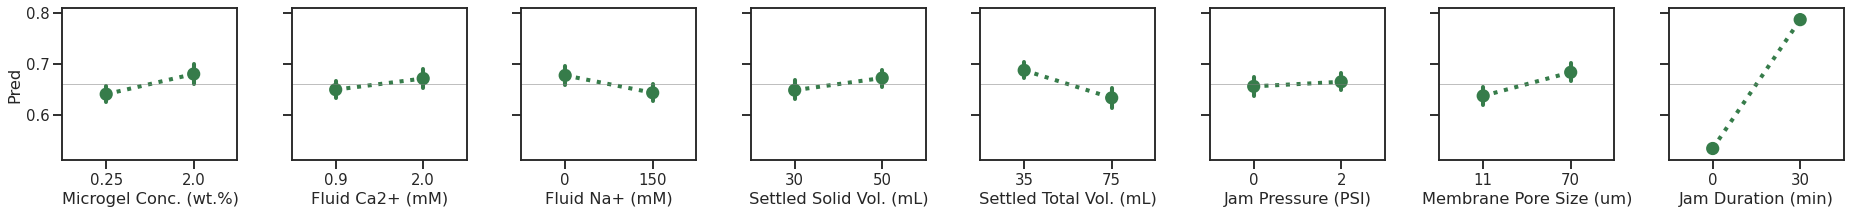

In [ ]:
# Define the columns you want to plot 
vars_to_iterate = X.columns

# Define the number of rows and columns 
rows=1;cols=len(vars_to_iterate)
fig,ax=plt.subplots(rows,cols,figsize=(cols*3.25,rows*3.25),sharey=True)

color = sns.color_palette(palette='Greens_d',n_colors=5)[3]

i=0
for variable in vars_to_iterate: 
  sns.pointplot(x=variable,y='Pred',data=other_vars_constant,ax=ax[i],ci=95,linestyles=':',color=color); 
  ax[i].axhline(other_vars_constant['Pred'].mean(),c='grey',alpha=0.5,linewidth=1); 
  i+=1
[ax[c].set_ylabel('') for c in range(1,cols)]
fig.tight_layout()

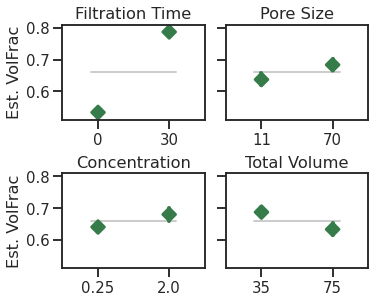

In [ ]:
rows=2;cols=2
fig,ax=plt.subplots(rows,cols,figsize=(cols*2.75,rows*2.25),sharey=True)

color = sns.color_palette(palette='Greens_d',n_colors=5)[3]; linestyles=':'; join=False; linewidth=2; markers='D'; scale=0.9; errwidth=None; capsize=0.2

sns.pointplot(x='Jam Duration (min)',y='Pred',data=other_vars_constant,ax=ax[0,0],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,0].set_title('Filtration Time')

sns.pointplot(x='Membrane Pore Size (um)',y='Pred',data=other_vars_constant,ax=ax[0,1],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[0,1].set_title('Pore Size'); 

sns.pointplot(x='Microgel Conc. (wt.%)',y='Pred',data=other_vars_constant,ax=ax[1,0],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,0].set_title('Concentration')

sns.pointplot(x='Settled Total Vol. (mL)',y='Pred',data=other_vars_constant,ax=ax[1,1],ci=95,linestyles=linestyles,markers=markers,color=color,join=join,scale=scale,errwidth=errwidth);
ax[1,1].set_title('Total Volume'); 

#[sns.despine(ax=ax,top=True,right=True,left=True,trim=True) for ax in plt.gcf().axes] #[sns.despine(ax=ax,top=True,right=True,left=False,trim=False) for ax in plt.gcf().axes] #sns.despine(ax=ax[0,0],top=True,right=True,left=False); sns.despine(ax=ax[0,1],top=True,right=True,left=True); 
ax[0,0].set_ylabel('Est. VolFrac'); ax[1,0].set_ylabel('Est. VolFrac'); ax[0,1].set_ylabel(''); ax[1,1].set_ylabel(''); 
[ax.axhline(other_vars_constant['Pred'].mean(),xmin=0.2,xmax=0.8,c='grey',alpha=0.4,linewidth=2,linestyle='-',zorder=-1) for ax in plt.gcf().axes] #[ax.axhline(other_vars_constant['Pred_probability'].mean(),xmin=0,xmax=1,c='grey',alpha=0.5,linewidth=1,linestyle='-',zorder=-1) for ax in plt.gcf().axes]; 
ax[0,0].set_yticks([0.6,0.7,0.8,]); #ax[0,0].set_yticklabels(['.4','.6','.8']); 
[ax.set_xlabel('') for ax in plt.gcf().axes]

fig.tight_layout(h_pad=0.5, w_pad=0.75)

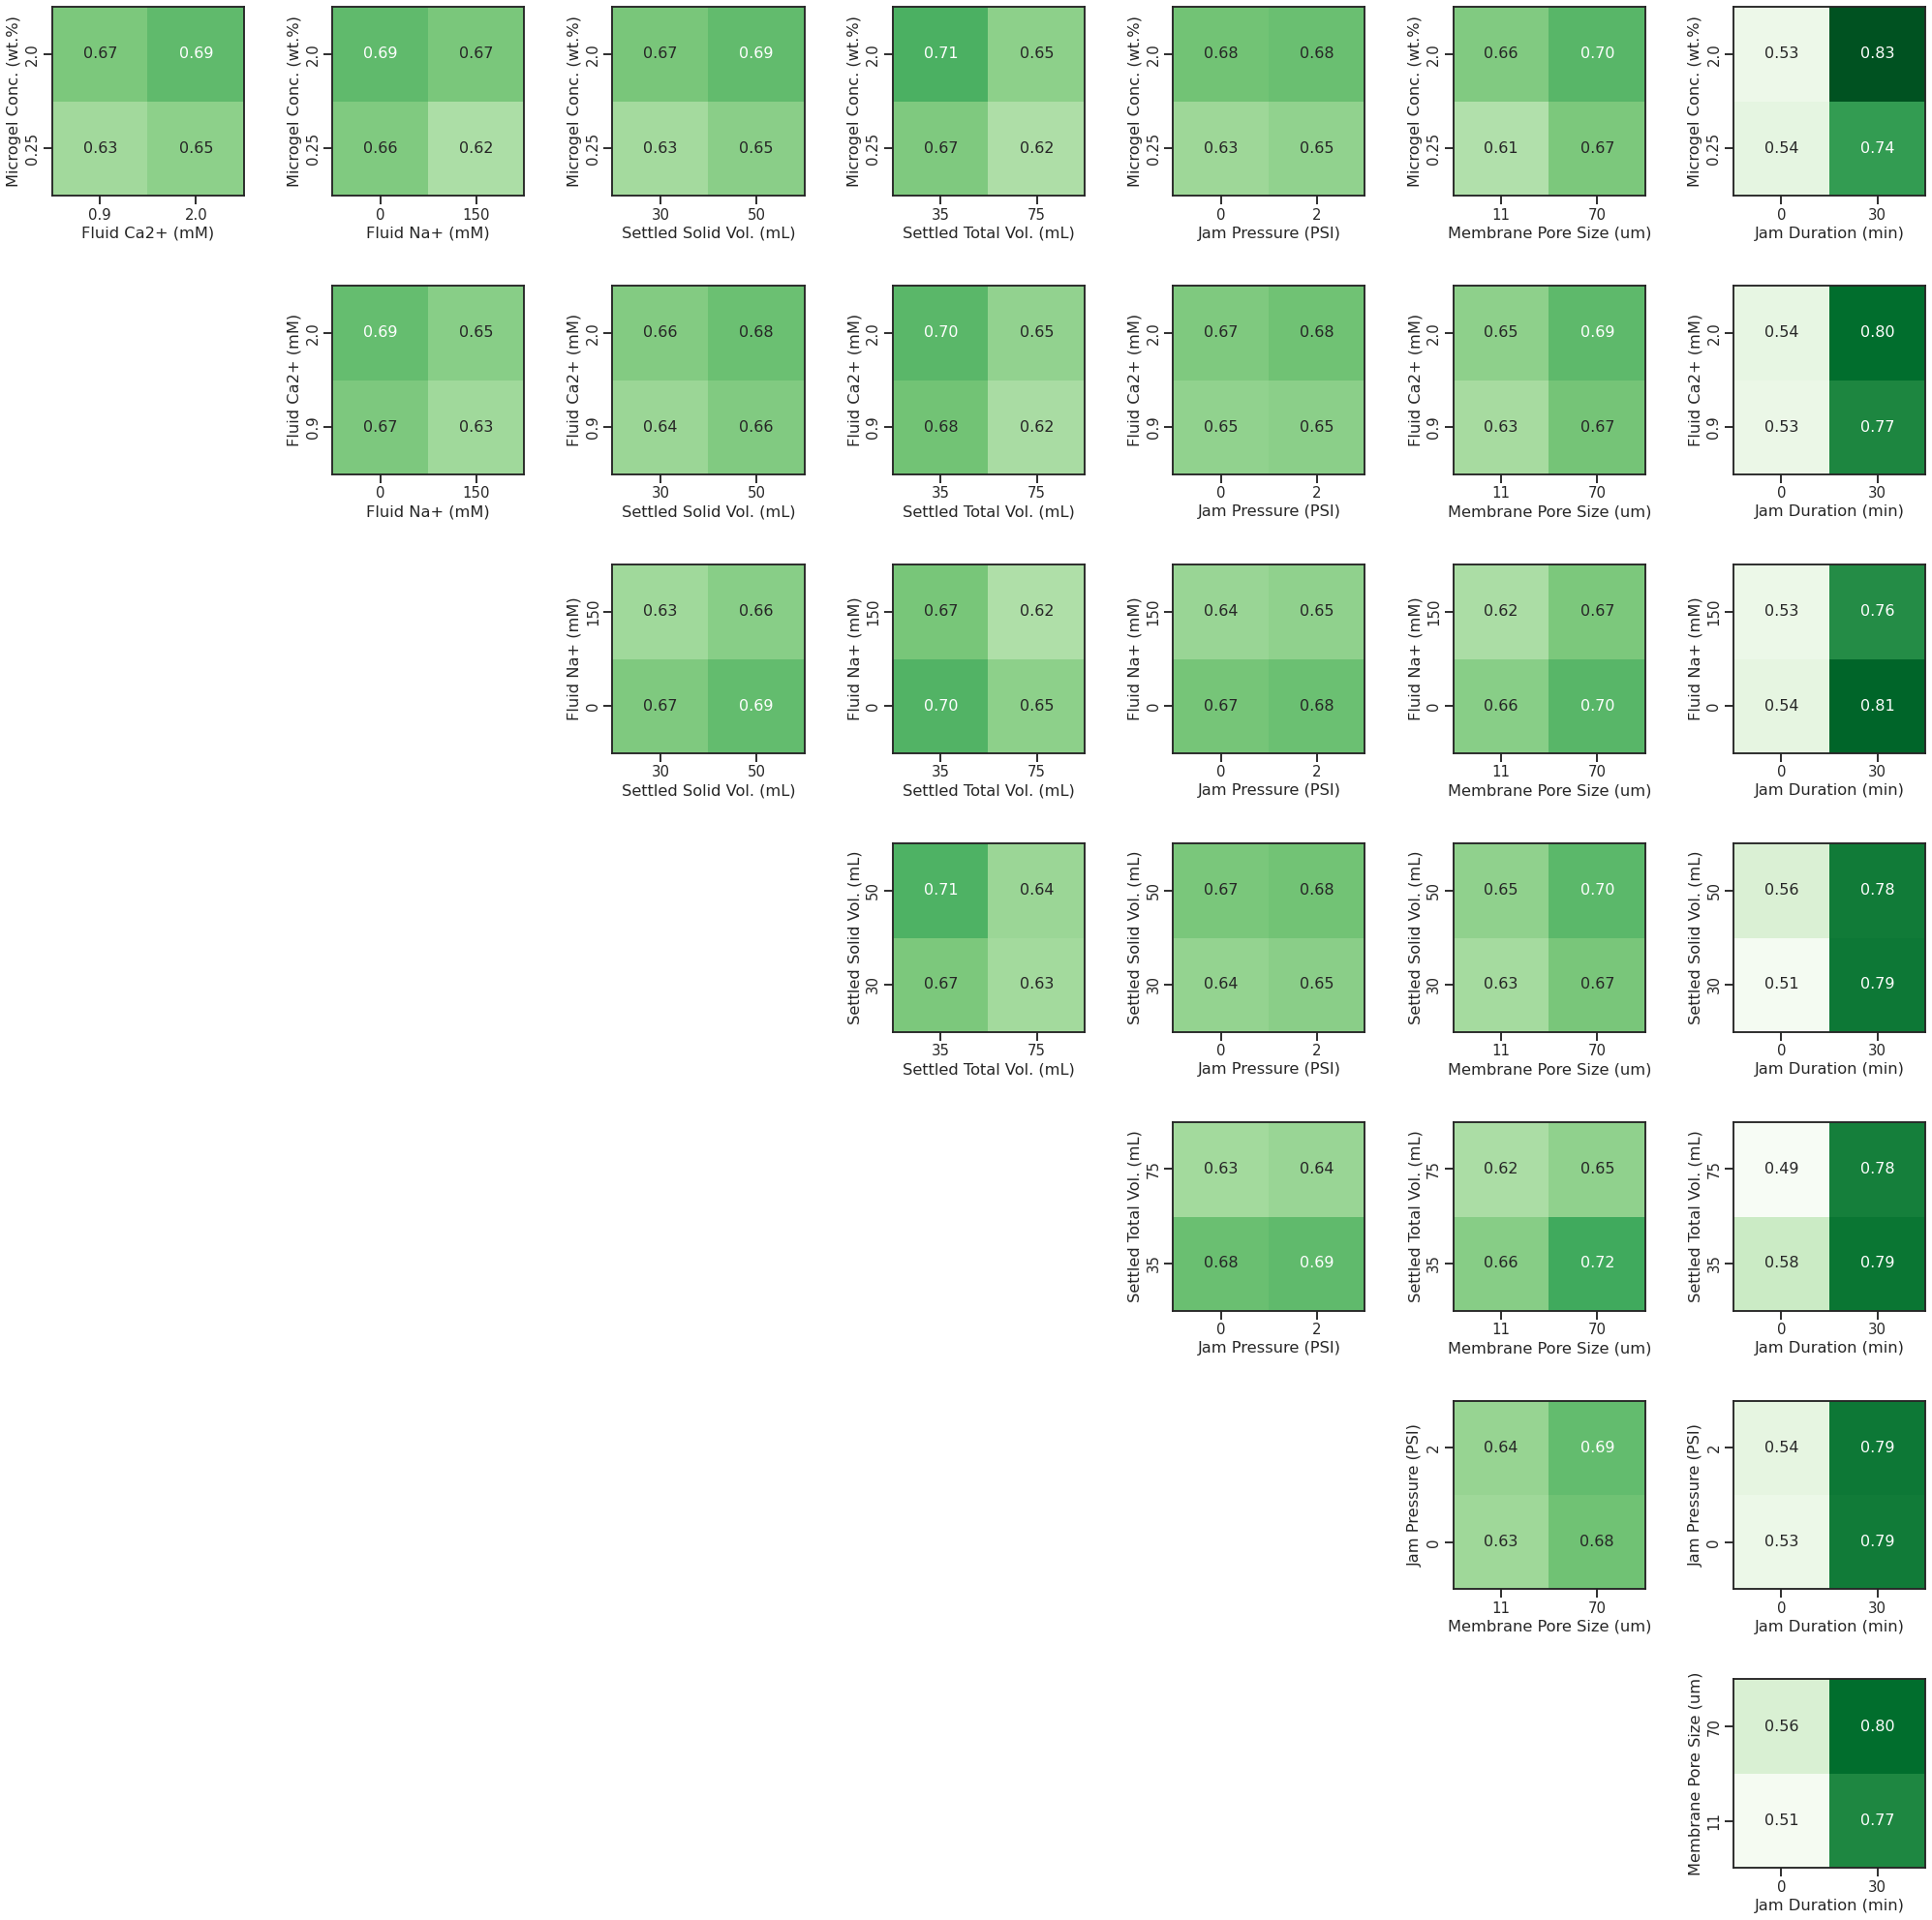

In [ ]:
# Define the columns you want to plot 
vars_to_iterate = X.columns

# Define the number of rows and columns 
rows=len(vars_to_iterate)-1;cols=len(vars_to_iterate)-1

# Define the figure 
fig,ax=plt.subplots(rows,cols,figsize=(cols*4, rows*4)); plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

# Define heatmap attributes 
vmin=0.5;vmax=.85;cmap='Greens';annot=True;annot_size = 16;linewidth=0

# Initialize the row indexer, the column indexer, and an another variable to keep track of where the columns should start on a new row 
r,c,c_init=0,0,0

for pair in itertools.combinations(vars_to_iterate,2):   
  
  #print(r,c,c_init); print(pair)
  
  sns.heatmap(other_vars_constant.pivot_table(index=pair[0],columns=pair[1],values='Pred'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax[r,c],linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)
  
  c+=1 # Mover over one column 

  if c == cols: # Check if you've reached the end of the row, in which case you need to move down by one and over by one 

    r+=1; c_init+=1; c=c_init # Move over one row, and then move over one column to maintain the diagonal structure of the matrix 

[ax.invert_yaxis() for ax in plt.gcf().axes] # Invert the y axis so the plot makes more sense

# Add the spines to each of the plots 
for ax in plt.gcf().axes: 
  for _, spine in ax.spines.items(): 
    spine.set_visible(True)

# Check if anything was actually added to the plot, and if there is no data you can delete the plot 
for ax in plt.gcf().axes: 
  if not ax.has_data(): 
    fig.delaxes(ax)

fig.tight_layout()

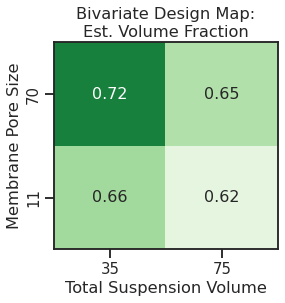

In [ ]:
rows=1;cols=1

fig,ax=plt.subplots(rows,cols,figsize=(cols*4.25, 4.5))

plt.subplots_adjust(wspace= 0.5, hspace= 0.5)

vmin=0.6;vmax=0.75;cmap='Greens';annot=True;annot_size = 16;linewidth=0

sns.heatmap(other_vars_constant.pivot_table(index='Membrane Pore Size (um)',columns='Settled Total Vol. (mL)',values='Pred'),vmin=vmin,vmax=vmax,cmap=cmap,ax=ax,linewidths=linewidth,annot=annot,annot_kws={'size':annot_size},fmt=".2f",cbar=False)

ax.invert_yaxis()

ax.set_xlabel('Total Suspension Volume'); ax.set_ylabel('Membrane Pore Size')

ax.set_title('Bivariate Design Map:\nEst. Volume Fraction')

for ax in plt.gcf().axes:
  for _, spine in ax.spines.items():
      spine.set_visible(True)

fig.tight_layout()

### Supplementary Evaluation

In [ ]:
# Basic information about X and y 
print('Matrix of X values:',X.shape[0],'observations and',X.shape[1],'features')
print('Feature names:',list(X.columns))
print('Vector of y values:',y.shape[0],'observations')
print('y name(s):',y.name)
print('Range of y values:',round(y.min(),2),'to',round(y.max(),2))
print('Mean of y values:',round(y.mean(),2))
print('Median of y values:',round(y.median(),2))
print('Standard deviation of y values:',round(y.std(),2))
print('Number of unique trials:',np.unique(groups).shape[0])

Matrix of X values: 196 observations and 8 features
Feature names: ['Microgel Conc. (wt.%)', 'Fluid Ca2+ (mM)', 'Fluid Na+ (mM)', 'Settled Solid Vol. (mL)', 'Settled Total Vol. (mL)', 'Jam Pressure (PSI)', 'Membrane Pore Size (um)', 'Jam Duration (min)']
Vector of y values: 196 observations
y name(s): Est. Vol. Fraction
Range of y values: 0.3 to 1.07
Mean of y values: 0.76
Median of y values: 0.8
Standard deviation of y values: 0.15
Number of unique trials: 29


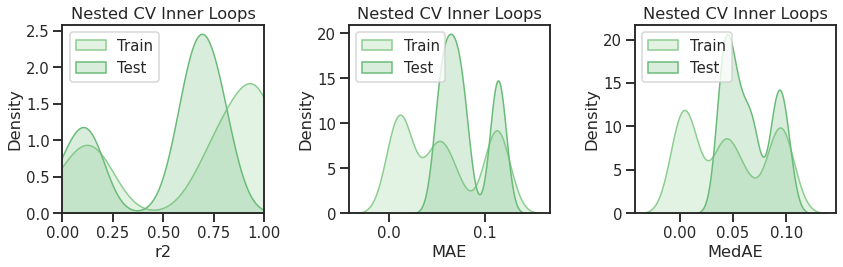

In [ ]:
# Plot the nested CV inner model evaluations 
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=compiled_inner_crossval['mean_train_'+scorer],shade=True,label='Train',ax=ax[indexer])
  sns.kdeplot(data=compiled_inner_crossval['mean_test_'+scorer],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Nested CV Inner Loops')
  indexer+=1
ax[0].set_xlim(0,1)
fig.tight_layout()

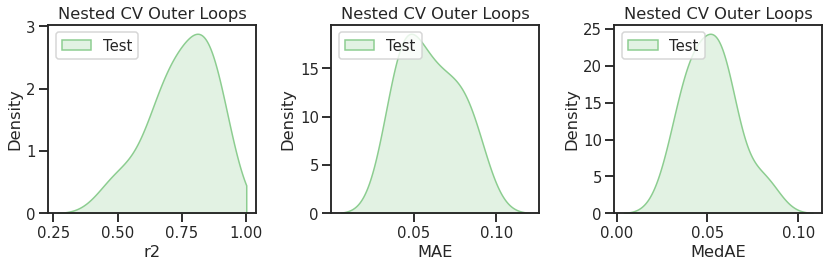

In [ ]:
# Plot the nested CV outer model evaluations
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=compiled_best_models['outer_'+scorer],clip=[0,1],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Nested CV Outer Loops')
  indexer+=1
fig.tight_layout()

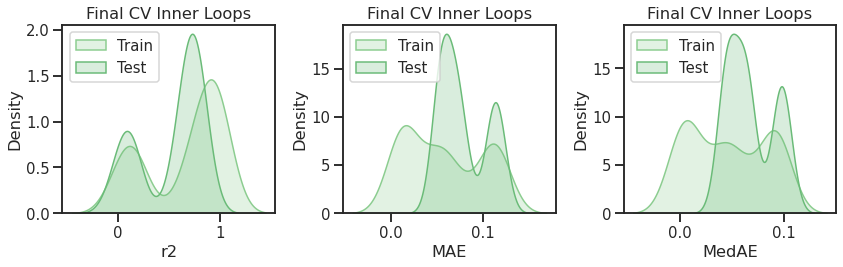

In [ ]:
# Plot the final CV inner model evaluations 
fig,ax=plt.subplots(1,len(scoring_dict.keys()),figsize=(len(scoring_dict.keys())*4,4))

indexer=0
for scorer in scoring_dict.keys(): 
  sns.kdeplot(data=final_search_results['mean_train_'+scorer],shade=True,label='Train',ax=ax[indexer])
  sns.kdeplot(data=final_search_results['mean_test_'+scorer],shade=True,label='Test',ax=ax[indexer])
  ax[indexer].set_xlabel(scorer); ax[indexer].legend(loc='upper left'); ax[indexer].set_title('Final CV Inner Loops')
  indexer+=1
fig.tight_layout()

In [ ]:
# Compute the permutation feature importance 
from sklearn.inspection import permutation_importance

level_0 = []; level_00 = []
for key in selected.keys(): 
  perm_imp = permutation_importance(selected[key],X,y,n_repeats=10,random_state=1,n_jobs=-1) # Compute the permutation feature importances and store the results 
  perm_imp_raw = pd.DataFrame(data=perm_imp.importances, index=X.columns) # Raw perm feat imp values for each var
  perm_imp_means = pd.DataFrame({'Var_names': X.columns,'PI_mean': perm_imp.importances_mean,'PI_std': perm_imp.importances_std}) # Mean and std feat imp for each var
  level_0.append(perm_imp_means); level_00.append(perm_imp_raw)

# Combine all of the results into a multi-index 
pi_means = pd.concat(level_0,keys=selected.keys()); pi_raw = pd.concat(level_00,keys=selected.keys())

# Melt the dataframe and rename the columns (makes it easier for plotting)
pi_raw_melt = pd.melt(pi_raw.reset_index(),id_vars=['level_0','level_1'],value_vars=pi_raw.columns).drop(columns='variable').rename(columns={'level_0':'Model','level_1':'variable','value':'Permutation Feature Importance'})

# Sort the feature importance (avereged between the two models) so that they are plotted from highest (top) to lowest (bottom) on the graph 
sorted_by_mean = pi_raw_melt.groupby('variable').mean().sort_values(by='Permutation Feature Importance',ascending=False).reset_index().rename(columns={'Permutation Feature Importance':'Avg PF Importance'})

pi_raw_melt_full = pd.merge(sorted_by_mean,pi_raw_melt,on='variable'); pi_raw_melt = pd.merge(sorted_by_mean.iloc[:6],pi_raw_melt,on='variable')

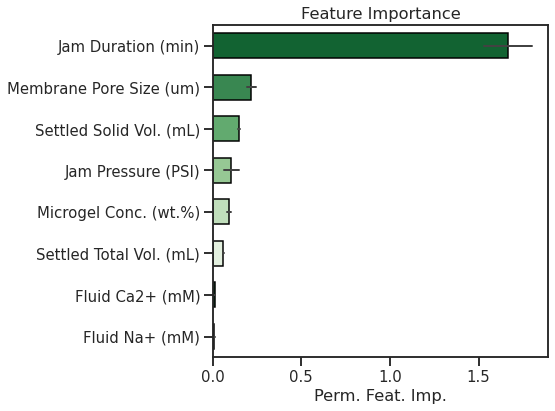

In [ ]:
fig = plt.figure(figsize=(8, 6))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

rows=1;cols=1

# Plot the permutation feature importance (bar plots for each variable - averaged) 

sub1 = fig.add_subplot(rows,cols,1) 

sns.barplot(y='variable',x='Permutation Feature Importance',data=pi_raw_melt_full,ax=sub1,edgecolor='k',errwidth=2,palette=sns.color_palette(palette='Greens_r'),alpha=1)

sub1.set_title('Feature Importance'); sub1.set_ylabel(''); sub1.set_xlabel('Perm. Feat. Imp.'); sub1.set_xlim(xmin=0)

def change_width_y(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_height(); diff = current_width - new_value

        patch.set_height(new_value) # change the bar width

        patch.set_y(patch.get_y() + diff * .5) # recenter the bar
change_width_y(sub1, .6)

fig.tight_layout()

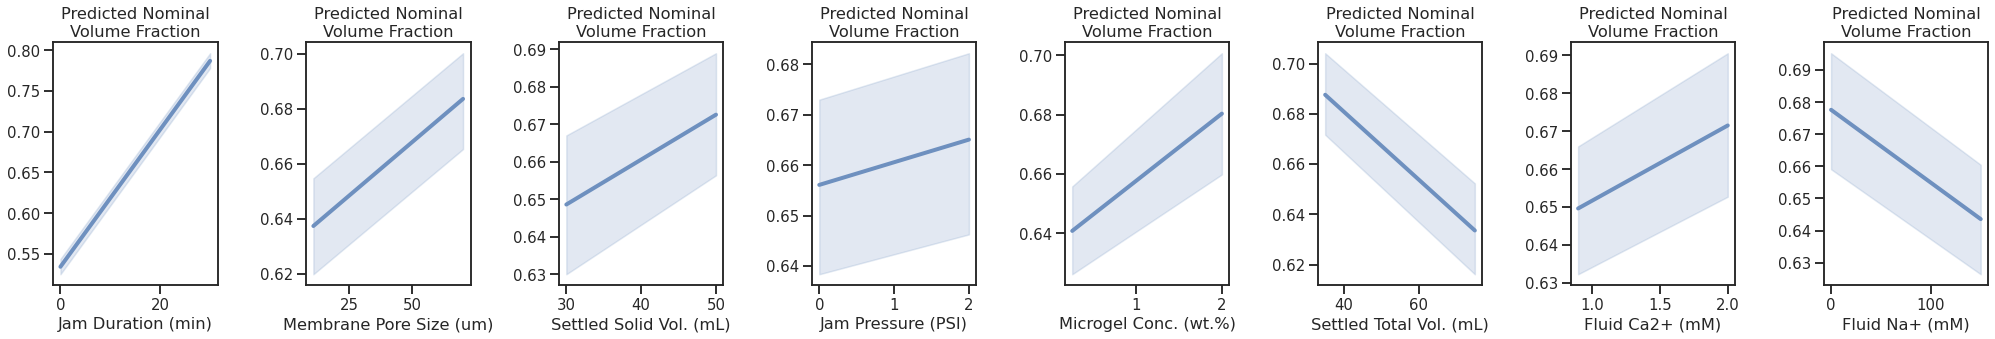

In [ ]:
# Plot the predicted values (given the n-dimensional cartesian product of unique feature values) along each possible feature axis 

yval = 'Pred'; title = 'Predicted Nominal\nVolume Fraction'; format = '%.2f' # Modify these as needed 

from matplotlib.ticker import FormatStrFormatter

ordered_preds = pi_raw_melt_full.groupby('variable').mean().sort_values(by='Permutation Feature Importance',ascending=False).index.values

fig = plt.figure(figsize=(len(ordered_preds)*3.5, 5))

plt.subplots_adjust(wspace= 0.25, hspace= 0.25)

rows=1;cols=len(ordered_preds) 

dict_for_pred_plots = {}
for i in range(len(ordered_preds)): 
  dict_for_pred_plots['sub'+str(i)] = fig.add_subplot(rows,cols,i+1)
  sns.lineplot(x=ordered_preds[i],y=yval,data=other_vars_constant,ax=dict_for_pred_plots['sub'+str(i)],linewidth=4,color=sns.color_palette(palette='vlag')[0],)
  dict_for_pred_plots['sub'+str(i)].set_title(title); dict_for_pred_plots['sub'+str(i)].set_ylabel('');
  dict_for_pred_plots['sub'+str(i)].yaxis.set_major_formatter(FormatStrFormatter(format))

fig.tight_layout()

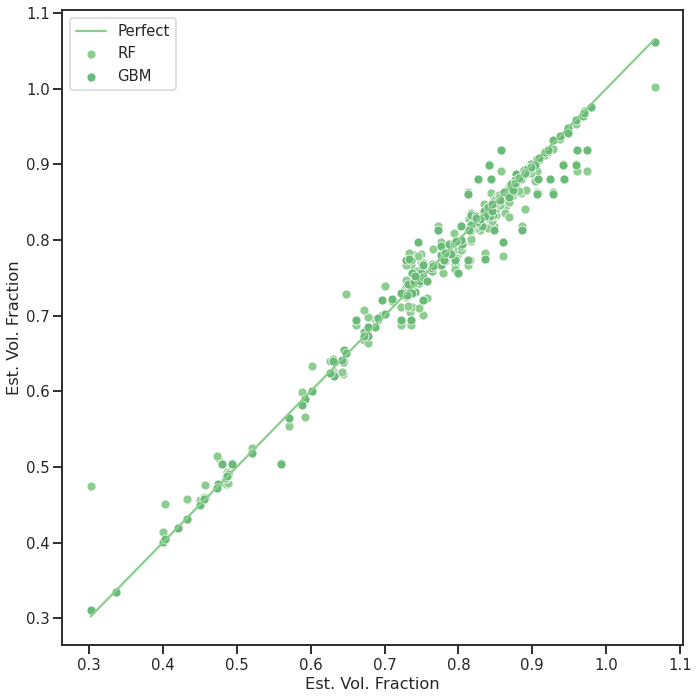

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))

sns.lineplot(x=y,y=y,label='Perfect')
sns.scatterplot(x=y,y=rf.predict(X),label='RF')
sns.scatterplot(x=y,y=gbm.predict(X),label='GBM')
#sns.lineplot(x=[0,1000],y=[np.mean(y),np.mean(y)],label='Average')
fig.tight_layout()

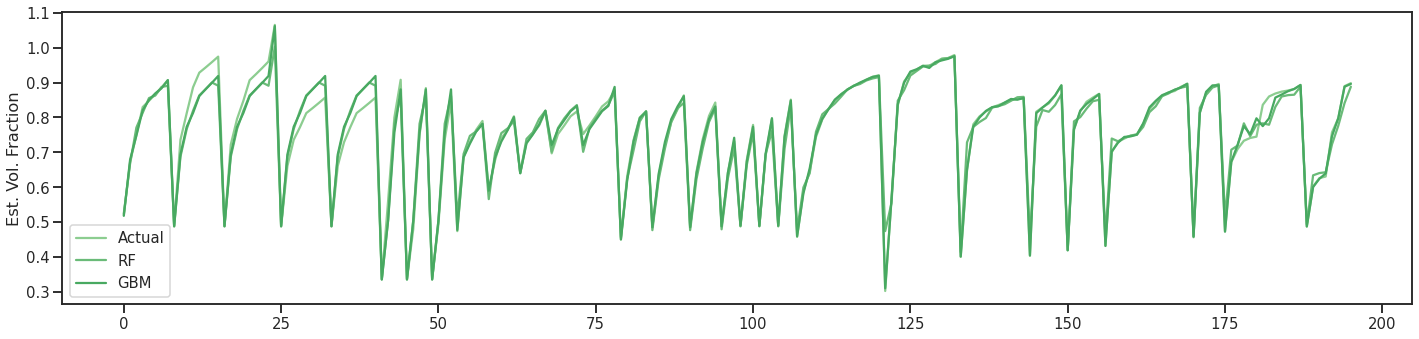

In [ ]:
fig,ax=plt.subplots(figsize=(20,5))
sns.lineplot(x=np.arange(len(y)),y=y,ax=ax,label='Actual')
sns.lineplot(x=np.arange(len(y)),y=rf.predict(X),ax=ax,label='RF')
sns.lineplot(x=np.arange(len(y)),y=gbm.predict(X),ax=ax,label='GBM')
fig.tight_layout()